### Импорты и настройки

In [1]:
import pandas as pd
import sqlalchemy
import re
import tqdm
from preprocessing import Players, Seasons
from features import Features

pd.set_option('max_columns', None)

db_name = 'postgres'
db_hostname = 'localhost'
db_user = 'postgres'
db_password = 'tttBBB777'
db_table = 'players_list'

engine = sqlalchemy.create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_hostname}/{db_name}')

In [2]:
season = pd.read_sql('select * from player_season', engine)
players = pd.read_sql('select * from player', engine)

### Препроцессинг

In [3]:
season_stats = Seasons.preprocess(season)
players = Players.preprocess(players)

### Подготовка фич

In [4]:
features = Features(players, season_stats)
features_df = features.gather_all_features()

Gathering league ratings...


  0%|                                                  | 0/108 [00:00<?, ?it/s]

Gathering age...
Gathering nationalities...


  0%|                                                   | 0/10 [00:00<?, ?it/s]

Gathering positions...


100%|██████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


Gathering dummies...
Gathering per-game stats...
Gathering lags stats...


100%|████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


Gathering aggregates...


100%|████████████████████████████████████████████| 4/4 [02:29<00:00, 37.30s/it]


#### Приводим в порядок колонки

In [5]:
non_features = ['season', 'team', 'league', 'player_id', 'year', 'name', 'id', 'position', 'age', 'nation', 'shoots', 'youth team', 'date_of_birth', 
                'birth_country', 'birth_city', 'nhl_rights', 'draft_team', 'nation_', 'assists', 'points', 'penalty', 'plus_minus', 'goals_per_game', 
                'assists_per_game', 'points_per_game', 'penalty_per_game', 'plus_minus_per_game']

target = 'goals'

# Для правильного сплита - сортируем по возрастанию сезона
features_df = features_df[features_df[target].isnull() == False].sort_values(['season', 'postseason_flag']).reset_index(drop=True)
features_df.drop(non_features, axis=1, inplace=True)
features_df.rename(columns = lambda x: x.replace('/', '_'), inplace=True)
features_df = features_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Построение модели

In [6]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [7]:
X = features_df[[x for x in features_df.columns if x != target]]
y = features_df[target]

tscv = TimeSeriesSplit()
gbm = LGBMRegressor(max_depth=13, num_leaves=60, learning_rate=0.05, n_estimators=500)

In [8]:
scores = []

for train_index, test_index in tqdm.tqdm(tscv.split(X), total=tscv.n_splits):
    model = gbm.fit(X.loc[train_index], y.loc[train_index])
    prediction = model.predict(X.loc[test_index])
    scores.append(mean_absolute_error(y.loc[test_index], prediction))

100%|████████████████████████████████████████████| 5/5 [02:24<00:00, 28.83s/it]


In [9]:
scores

[3.3686066730021706,
 2.881533577265086,
 2.7669368570009483,
 2.5830463300235875,
 2.5293746655874876]

In [11]:
model = gbm.fit(X, y)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

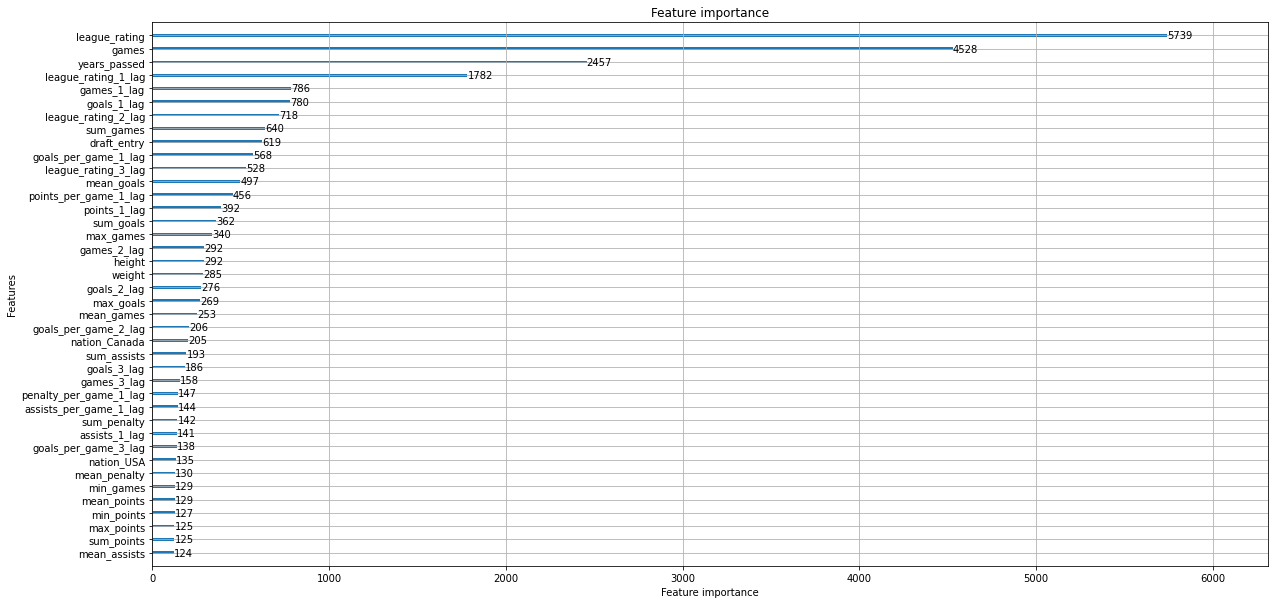

In [12]:
plot_importance(model, max_num_features=40, figsize=(20, 10))